In [1]:
# Imports
from PIL import Image, ImageFilter
import numpy as np
from transformers import pipeline

In [2]:
# Image segmentation model from hugging face hub

model = pipeline("image-segmentation")

#[{'label': 'cat',
#  'mask': mask_code,
#  'score': 0.999}
# ...]

No model was supplied, defaulted to facebook/detr-resnet-50-panoptic (https://huggingface.co/facebook/detr-resnet-50-panoptic)


In [3]:
image = Image.open("test_images/ai_human.webp", mode='r')
pred = model(image)

In [7]:
pred

[{'score': 0.9996769428253174,
  'label': 'person',
  'mask': <PIL.Image.Image image mode=L size=1920x1080>},
 {'score': 0.9967960715293884,
  'label': 'bottle',
  'mask': <PIL.Image.Image image mode=L size=1920x1080>},
 {'score': 0.9880407452583313,
  'label': 'LABEL_199',
  'mask': <PIL.Image.Image image mode=L size=1920x1080>},
 {'score': 0.996527373790741,
  'label': 'cell phone',
  'mask': <PIL.Image.Image image mode=L size=1920x1080>},
 {'score': 0.9997614026069641,
  'label': 'person',
  'mask': <PIL.Image.Image image mode=L size=1920x1080>},
 {'score': 0.9998278617858887,
  'label': 'person',
  'mask': <PIL.Image.Image image mode=L size=1920x1080>},
 {'score': 0.9992454051971436,
  'label': 'person',
  'mask': <PIL.Image.Image image mode=L size=1920x1080>}]

In [4]:
pred_object_list = [x['label'] for x in pred]
pred_object_list

['person', 'bottle', 'LABEL_199', 'cell phone', 'person', 'person', 'person']

In [107]:
mask_array = np.asarray(pred[4]['mask'])/255
image_array = np.asarray(image)

In [108]:
mask_array_three_channel = np.zeros_like(image_array)
mask_array_three_channel[:,:,0] = mask_array
mask_array_three_channel[:,:,1] = mask_array
mask_array_three_channel[:,:,2] = mask_array

In [109]:
segmented_image = image_array*mask_array_three_channel

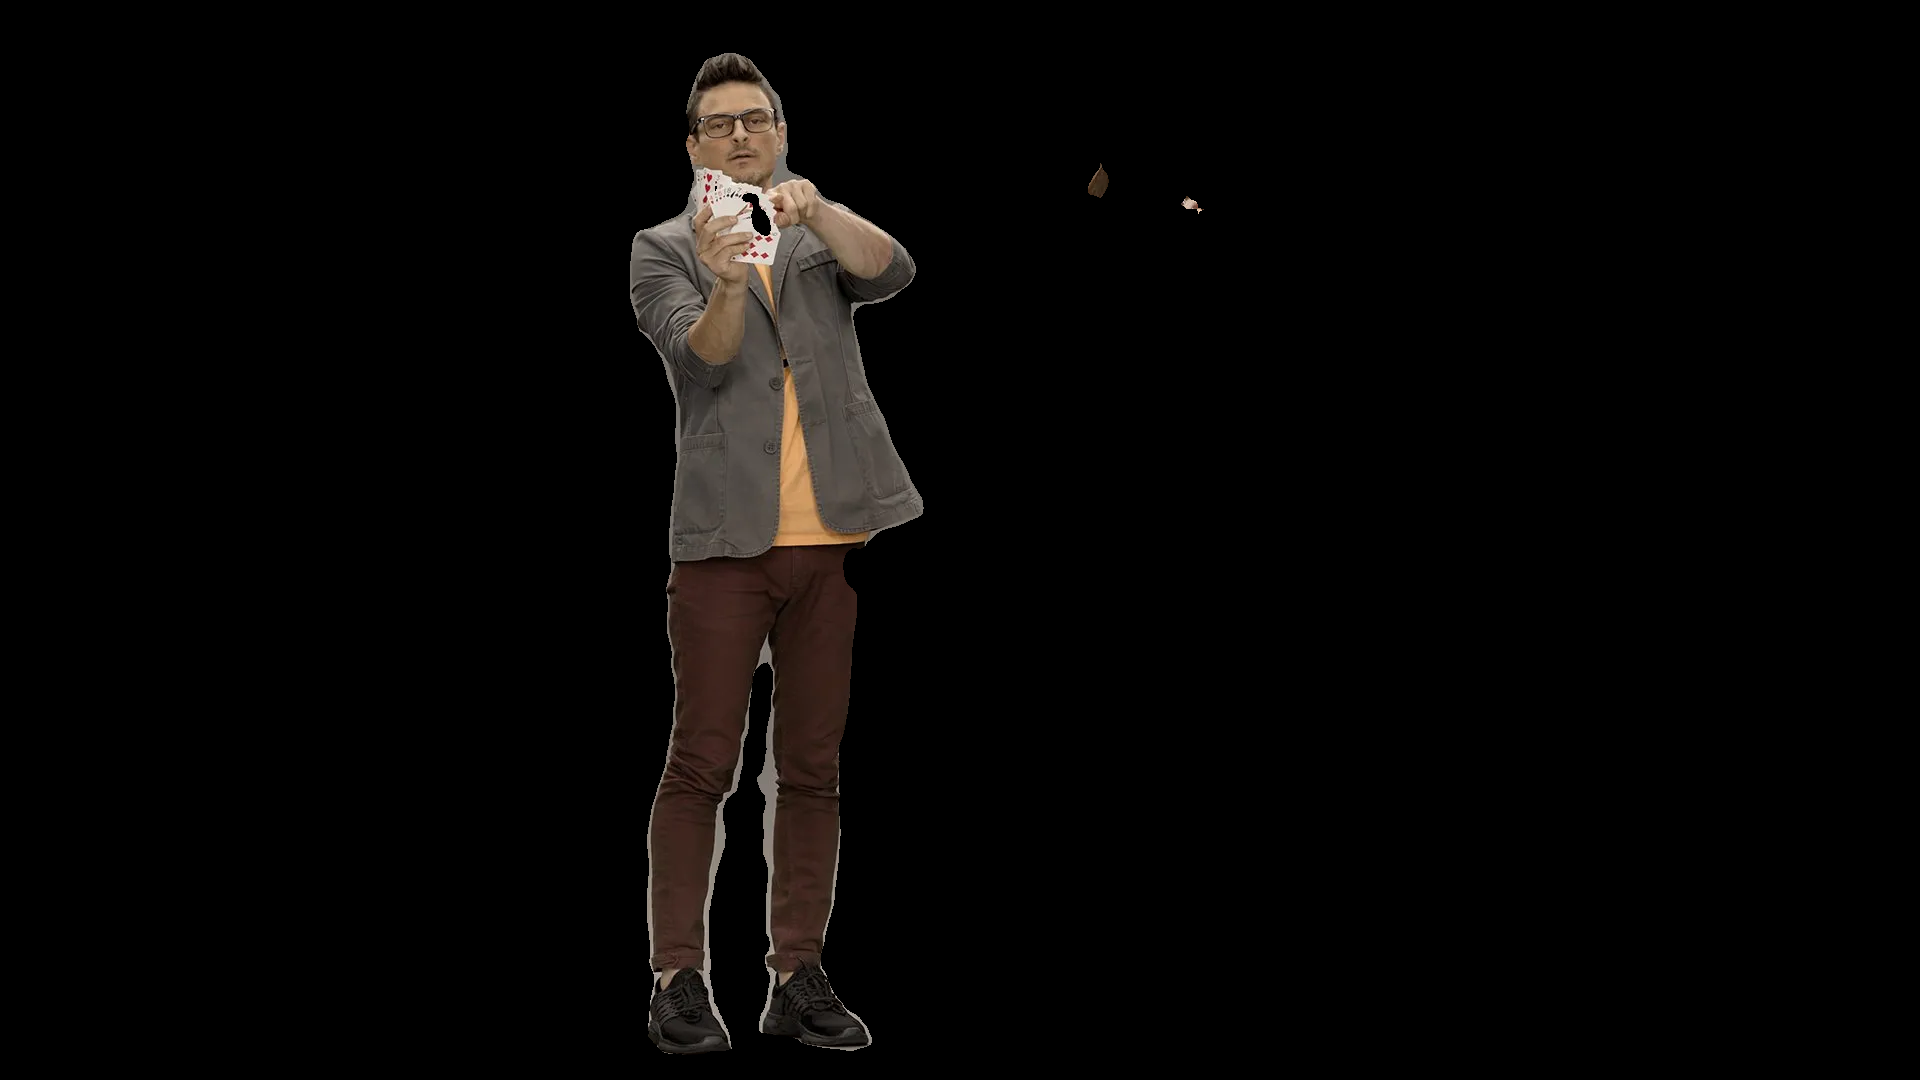

In [110]:
display(Image.fromarray(segmented_image.astype(np.uint8)))

In [120]:
# blur_image = np.asarray(image.filter(ImageFilter.BLUR))

blur_image = np.asarray(image.filter(ImageFilter.GaussianBlur(radius=5)))

In [121]:
mask_array_three_channel_invert = 1-mask_array_three_channel

In [122]:
np.min(mask_array_three_channel_invert)

0

In [123]:
np.max(mask_array_three_channel_invert), np.max(mask_array_three_channel)

(1, 1)

In [124]:
blur_image.shape

(1080, 1920, 3)

In [125]:
mask_array_three_channel_invert.shape

(1080, 1920, 3)

In [126]:
blur_image_reverse_mask = blur_image*mask_array_three_channel_invert

In [127]:
np.max(blur_image_reverse_mask), np.min(blur_image_reverse_mask)

(250, 0)

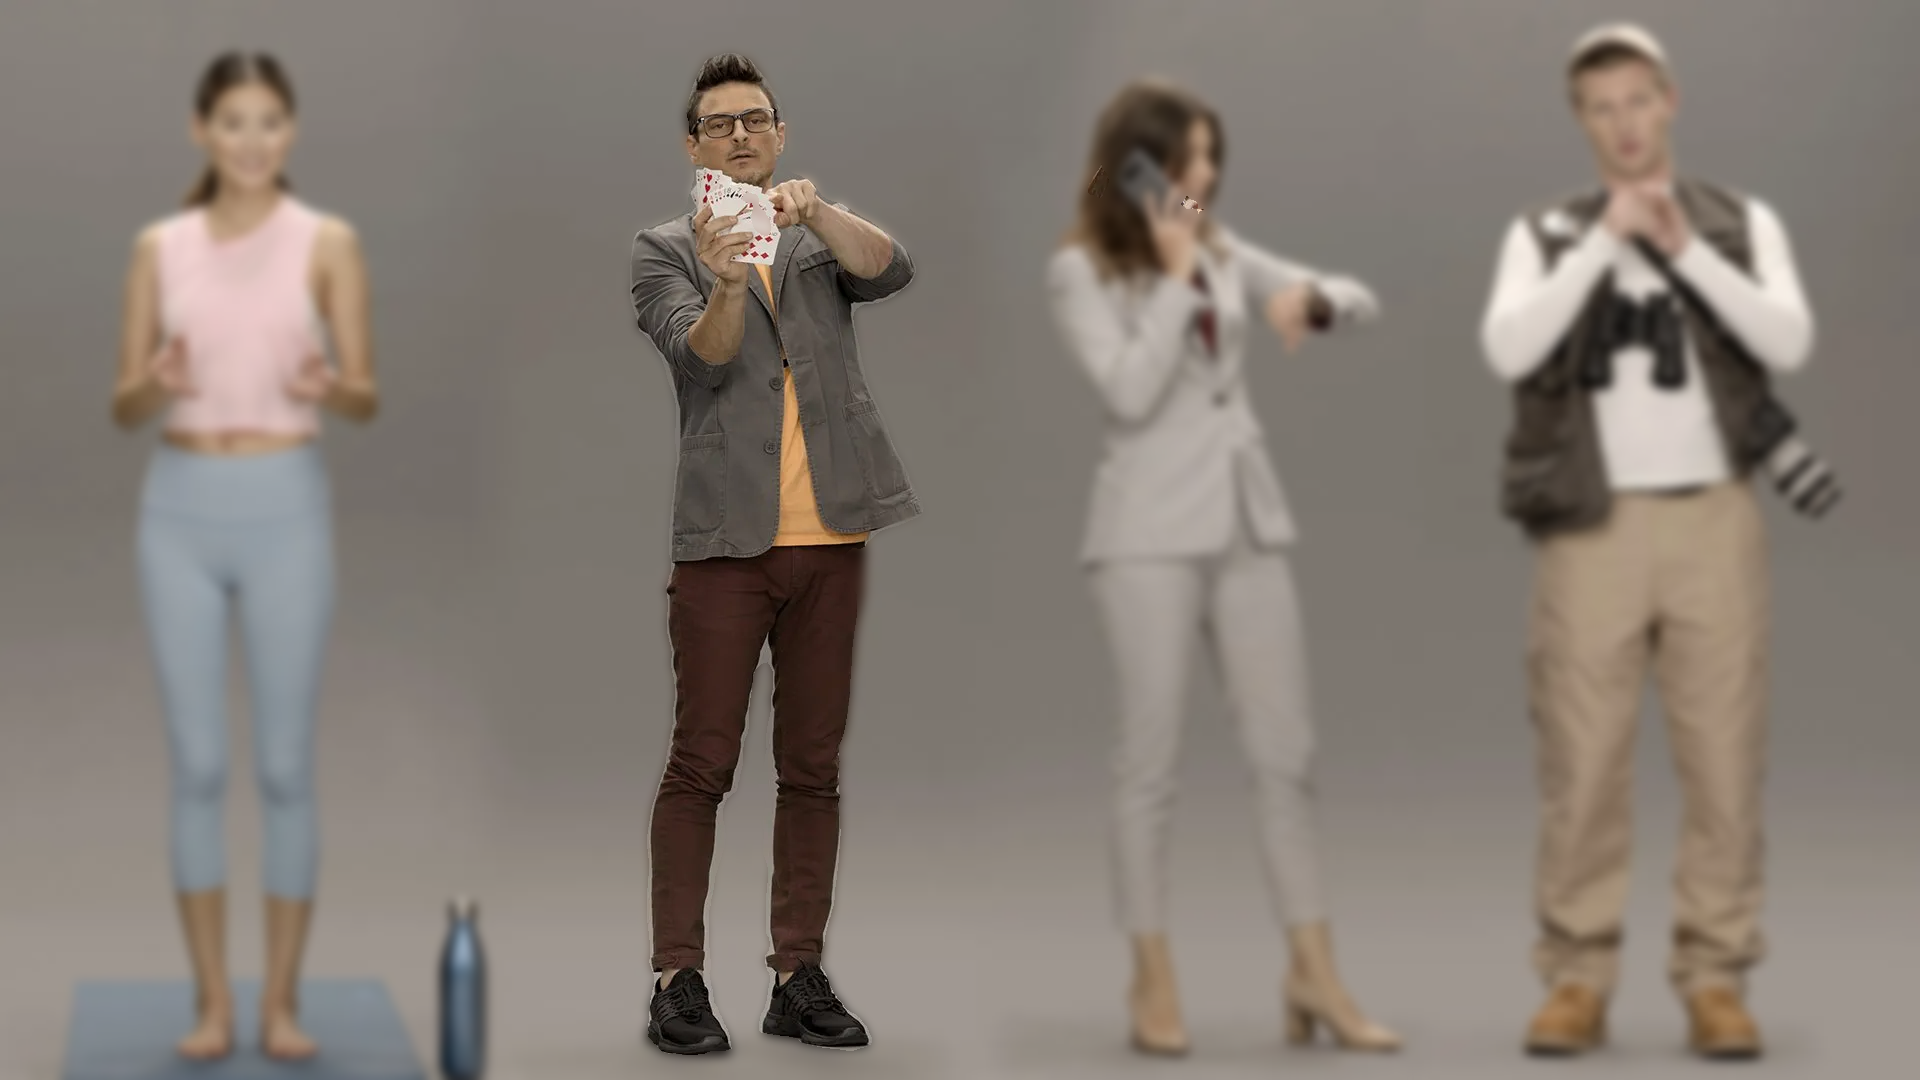

In [128]:
display(Image.fromarray((blur_image_reverse_mask).astype(np.uint8)+segmented_image.astype(np.uint8)))
# display(Image.fromarray(segmented_image.astype(np.uint8)))